<a href="https://colab.research.google.com/github/PaulowniaTree/Mini-Project-3/blob/bumsu/%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5%2Ccrop%2C%EC%A0%84%EC%B2%98%EB%A6%AC_%EC%B6%94%EA%B0%80%2C_%ED%95%99%EC%8A%B5%EB%A5%A0_%3D_0_001%2C_%EB%B0%B0%EC%B9%98_%3D_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Classifier(ResNet152)

In [1]:
import torch # 파이토치 기본 라이브러리

import torchvision
from torchvision import datasets # torchvision에서 제공하는 데이터셋
from torchvision import transforms # 이미지 변환기능을 제공하는 패키지

# torch.utils.data : 파이토치 데이터 로딩 유틸리티
from torch.utils.data import DataLoader # 모델 훈련에 사용할 수 있는 미니 배치 구성하고
                                        # 매 epoch마다 데이터를 샘플링, 병렬처리 등의 일을 해주는 함수

from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy

In [2]:
!nvidia-smi

Wed Apr 19 02:53:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cbs5806","key":"daccab7575d8c1b29955723bf94416b4"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!ls -1ha kaggle.json

kaggle.json


In [8]:
!kaggle datasets download -d miljan/stanford-dogs-dataset-traintest

 99% 391M/393M [00:18<00:00, 25.1MB/s]
100% 393M/393M [00:18<00:00, 21.9MB/s]


In [9]:
!unzip stanford-dogs-dataset-traintest.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1066.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1140.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1200.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1270.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1299.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1318.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1409.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_158.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1615.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1622.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1669.jpg  
  inflating: cropped/train/n02102973-Irish_water_spaniel/n02102973_1714.jpg  
  inflating: cropped/train/n0

## 1. 데이터 불러오기

In [83]:
data_dir = '/content/cropped/cropped/'

In [84]:
# Compose를 통해 원하는 전처리기를 차례대로 넣을 수 있음
transform = transforms.Compose([transforms.Resize([224, 224]), 
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [85]:
trainset = datasets.ImageFolder(data_dir+ 'train', transform = transform)
testset = datasets.ImageFolder(data_dir+ 'test', transform = transform)

In [86]:
print(type(trainset), len(trainset))
print(type(testset), len(testset))

<class 'torchvision.datasets.folder.ImageFolder'> 12000
<class 'torchvision.datasets.folder.ImageFolder'> 8580


In [87]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [88]:
print(type(trainset.targets), len(trainset.targets), trainset.targets[:5], trainset.targets[-5:])

<class 'list'> 12000 [0, 0, 0, 0, 0] [119, 119, 119, 119, 119]


In [89]:
from sklearn.model_selection import train_test_split

train_indices, valid_indices, _, _ = train_test_split(
                            range(len(trainset)), # X의 index
                            trainset.targets, # y
                            stratify=trainset.targets, # target의 비율이 train과 valid에 그대로 반영되게
                            test_size= 0.2, random_state=42)

In [90]:
len(train_indices), len(valid_indices) # 80%, 20%

(9600, 2400)

In [91]:
from torch.utils.data import Subset
train_set = Subset(trainset, train_indices)
valid_set = Subset(trainset, valid_indices)

In [92]:
print(type(train_set), len(train_set))
print(type(valid_set), len(valid_set))
print(type(testset), len(testset))

<class 'torch.utils.data.dataset.Subset'> 9600
<class 'torch.utils.data.dataset.Subset'> 2400
<class 'torchvision.datasets.folder.ImageFolder'> 8580


## 2. 데이터 시각화

In [93]:
labels_map = {}
for i, name in enumerate(trainset.classes) :
    name=name[10:]
    labels_map[i]=name     
print(labels_map) # Printing some species

{0: 'Chihuahua', 1: 'Japanese_spaniel', 2: 'Maltese_dog', 3: 'Pekinese', 4: 'Shih-Tzu', 5: 'Blenheim_spaniel', 6: 'papillon', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound', 10: 'basset', 11: 'beagle', 12: 'bloodhound', 13: 'bluetick', 14: 'black-and-tan_coonhound', 15: 'Walker_hound', 16: 'English_foxhound', 17: 'redbone', 18: 'borzoi', 19: 'Irish_wolfhound', 20: 'Italian_greyhound', 21: 'whippet', 22: 'Ibizan_hound', 23: 'Norwegian_elkhound', 24: 'otterhound', 25: 'Saluki', 26: 'Scottish_deerhound', 27: 'Weimaraner', 28: 'Staffordshire_bullterrier', 29: 'American_Staffordshire_terrier', 30: 'Bedlington_terrier', 31: 'Border_terrier', 32: 'Kerry_blue_terrier', 33: 'Irish_terrier', 34: 'Norfolk_terrier', 35: 'Norwich_terrier', 36: 'Yorkshire_terrier', 37: 'wire-haired_fox_terrier', 38: 'Lakeland_terrier', 39: 'Sealyham_terrier', 40: 'Airedale', 41: 'cairn', 42: 'Australian_terrier', 43: 'Dandie_Dinmont', 44: 'Boston_bull', 45: 'miniature_schnauzer', 46: 'giant_schnauzer'

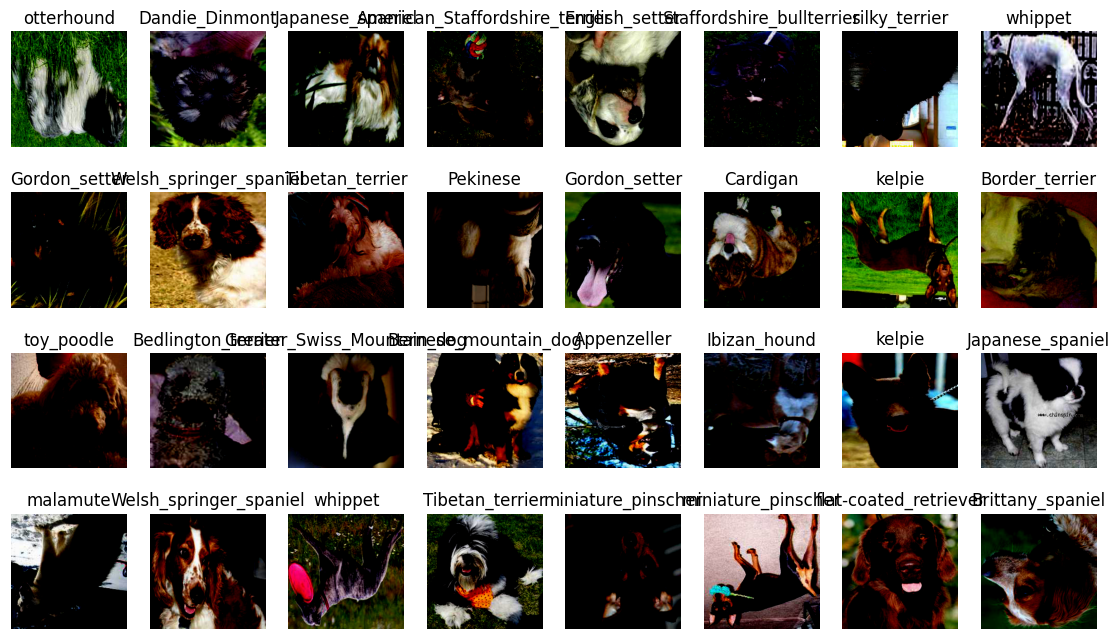

In [94]:
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
axes = axes.flatten()

for i in range(32):
  rand_i = np.random.randint(0, len(trainset))
  image, label= trainset[rand_i][0].permute(1, 2, 0), trainset[rand_i][1]
  axes[i].axis('off')
  axes[i].imshow(image)
  axes[i].set_title(labels_map[label])

## 3. 데이터 적재

In [95]:
batch_size = 16 # 16 -> 4
# dataloader = DataLoader(데이터셋, 배치사이즈, 셔플여부.....)
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # 훈련용 50000개의 데이터를 100개씩 준비
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False) # 검증용 10000개의 데이터를 100개씩 준비
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # 테스트용 10000개의 데이터를 100개씩 준비

In [96]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 600
<class 'torch.utils.data.dataloader.DataLoader'> 150
<class 'torch.utils.data.dataloader.DataLoader'> 537


In [97]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images.size(), labels.size()

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

## 4. 모델 생성

In [98]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [99]:
import torchvision.models as models

# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models

model = models.resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')

In [100]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [101]:
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True)

In [102]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
for parameter in model.parameters():
  parameter.requires_grad = False # 학습이 안되게 고정

for parameter in model.fc.parameters():
  parameter.requires_grad = True # 학습이 가능한 상태

In [104]:
model.fc

Linear(in_features=2048, out_features=120, bias=True)

In [105]:
out = model(images.to(device))
out.shape

torch.Size([16, 120])

## 5. 모델 컴파일 (손실함수, 옵티마이저 선택)

In [106]:
learning_rate = 0.0001
# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저(최적화함수, 예:경사하강법)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 규제의 강도 설정 weight_decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Learning Rate Schedule
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

# 모니터링하고 있는 값(예:valid_loss)의 최소값(min) 또는 최대값(max) patience 기간동안 줄어들지 않을 때(OnPlateau) lr에 factor(0.1)를 곱해주는 전략
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [107]:
from torchsummary import summary

In [108]:
# summary(모델, (채널, 인풋사이즈))
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## 6. 모델 훈련

In [110]:
def validate(model, validloader, loss_fn):
  total = 0   
  correct = 0
  valid_loss = 0
  valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.size()[0], 784)

      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    valid_accuracy = correct / total
  
  return valid_loss, valid_accuracy

In [111]:
writer = SummaryWriter()

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
  steps = 0
  steps_per_epoch = len(trainloader) 
  min_loss = 1000000
  max_accuracy = 0
  trigger = 0
  patience = 7 

  for epoch in range(epochs):
    model.train() # 훈련 모드
    train_loss = 0
    for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      steps += 1
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.shape[0], 784) 

      # 2. 전방향(forward) 예측
      predict = model(images) # 예측 점수
      loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

      # 3. 역방향(backward) 오차(Gradient) 전파
      optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
      loss.backward() # 모델파리미터들의 Gradient 전파

      # 4. 경사 하강법으로 모델 파라미터 업데이트
      optimizer.step() # W <- W -lr*Gradient

      train_loss += loss.item()
      if (steps % steps_per_epoch) == 0 : 
        model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
        valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

        # tensorboard 시각화를 위한 로그 이벤트 등록
        writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
        writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
        writer.add_scalars('Train Loss and Valid Loss',
                          {'Train' : train_loss/len(trainloader),
                            'Valid' : valid_loss/len(validloader)}, epoch+1)
        writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)
        # -------------------------------------------

        print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
              'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
              'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
              'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
              )
        
        # Best model 저장    
        # option 1 : valid_loss 모니터링
        # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
        #   min_loss = valid_loss
        #   best_model_state = deepcopy(model.state_dict())          
        #   torch.save(best_model_state, 'best_checkpoint.pth')     
        
        # option 2 : valid_accuracy 모니터링      
        if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
          max_accuracy = valid_accuracy
          best_model_state = deepcopy(model.state_dict())          
          torch.save(best_model_state, 'best_checkpoint.pth')  
        # -------------------------------------------

        # Early Stopping (조기 종료)
        if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
          trigger += 1
          print('trigger : ', trigger)
          if trigger > patience:
            print('Early Stopping !!!')
            print('Training loop is finished !!')
            writer.flush()   
            return
        else:
          trigger = 0
          min_loss = valid_loss
        # -------------------------------------------

        # Learning Rate Scheduler
        scheduler.step(valid_loss)
        # -------------------------------------------
        
  writer.flush()
  return  

In [112]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)
writer.close()

Epoch : 1/55....... Train Loss : 4.362 Valid Loss : 4.037 Valid Accuracy : 0.371
Epoch : 2/55....... Train Loss : 3.632 Valid Loss : 3.496 Valid Accuracy : 0.535
Epoch : 3/55....... Train Loss : 3.106 Valid Loss : 3.094 Valid Accuracy : 0.585
Epoch : 4/55....... Train Loss : 2.702 Valid Loss : 2.728 Valid Accuracy : 0.613
Epoch : 5/55....... Train Loss : 2.400 Valid Loss : 2.472 Valid Accuracy : 0.632
Epoch : 6/55....... Train Loss : 2.131 Valid Loss : 2.238 Valid Accuracy : 0.649
Epoch : 7/55....... Train Loss : 1.921 Valid Loss : 2.114 Valid Accuracy : 0.649
Epoch : 8/55....... Train Loss : 1.773 Valid Loss : 1.902 Valid Accuracy : 0.665
Epoch : 9/55....... Train Loss : 1.623 Valid Loss : 1.763 Valid Accuracy : 0.678
Epoch : 10/55....... Train Loss : 1.525 Valid Loss : 1.714 Valid Accuracy : 0.679
Epoch : 11/55....... Train Loss : 1.435 Valid Loss : 1.666 Valid Accuracy : 0.673
Epoch : 12/55....... Train Loss : 1.357 Valid Loss : 1.532 Valid Accuracy : 0.683
Epoch : 13/55....... Trai

##7. 모델 예측

In [113]:
# testloader에서 미니 배치 가져오기
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

# random한 index로 이미지 한장 준비하기
rnd_idx = 1
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) tensor(0, device='cuda:0')


In [114]:
images[rnd_idx].shape

torch.Size([3, 224, 224])

In [115]:
# not Flatten!
# flattend_img = images[rnd_idx].view(1, 784)

# 준비된 이미지로 예측하기
model.eval()
with torch.no_grad():
  logit = model(images[rnd_idx].unsqueeze(0)) # model.forward()에서는 배치가 적용된 4차원 입력 기대

pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx]) # True : 잘 예측

tensor([False], device='cuda:0')


pred: tensor([110], device='cuda:0') labels: tensor(0, device='cuda:0')
Brabancon_griffon Chihuahua


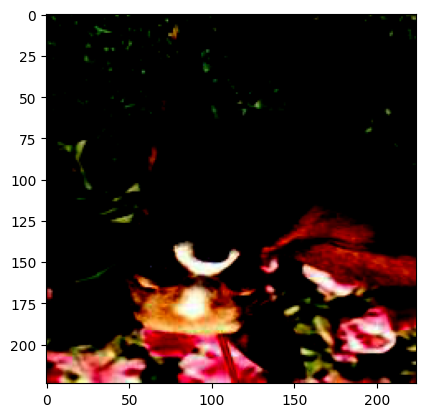

In [116]:
print("pred:", pred, "labels:", labels[rnd_idx])
print(labels_map[pred.cpu().item()], labels_map[labels[rnd_idx].cpu().item()])
plt.imshow(images[rnd_idx].permute(1, 2, 0).cpu())

##8. 모델 평가

In [117]:
def evaluation(model, testloader, loss_fn):
  total = 0   
  correct = 0
  test_loss = 0
  test_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in testloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten
      # images.resize_(images.size()[0], 784)
      
      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      test_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    test_accuracy = correct / total
   
  print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
        'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 1.060 Test Accuracy : 0.729


##9. 모델 저장

In [118]:
model.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [119]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [120]:
# 시간이 흐른뒤 다시 모델 가져오기
last_state_dict = torch.load('last_checkpoint.pth')

In [121]:
last_state_dict.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [122]:
# 읽어들인 모델 파라미터는 모델 아키텍처에 연결을 시켜줘야 함
# load_state_dict() 사용
last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [123]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

Test Loss : 1.074 Test Accuracy : 0.723


In [124]:
# valid loss or accuracy 기준 best model
best_state_dict = torch.load('best_checkpoint.pth')
best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [125]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

Test Loss : 1.057 Test Accuracy : 0.724
